In [1]:
import numpy as np
import scanpy as sc
import os

In [2]:
wd = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93vel/atlas_building/data"

In [3]:
ref_dir = os.path.join(wd, "reference")

### Load data

In [4]:
adata_list = []

The mature reference was chosen as follows: We inspected the data sets included in the Human Lung Cell Atlas (https://doi.org/10.1038/s41591-023-02327-2), which the authors list in Supplementary Table 1. We picked the Barbry_Leroy_2020 data set because it had already been published, contained data obtained from healthy, living invididuals, and was included in the HLCA core reference. We downloaded the data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE143868. Our mature and fetal reference contain a similar number of cells (about 80,000 and 90,000, respectively).

In [5]:
# Store the data you downloaded in ref_dir, the reference directory 
# The reference directory cannot contain any folders other than the mature reference data folders

for folder_name in os.listdir(ref_dir):
    # Check if the item in the directory is a folder
    if os.path.isdir(os.path.join(ref_dir, folder_name)):
        folder_path = os.path.join(ref_dir, folder_name)
        adata = sc.read_10x_mtx(folder_path, var_names='gene_symbols')
        adata_list.append(adata)

In [6]:
big_adata = sc.AnnData.concatenate(*adata_list, join='outer', batch_key='sample')
big_adata

/dss/dsshome1/06/di93vel/.conda/envs/heoa_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 82299 × 32739
    obs: 'sample'
    var: 'gene_ids'

### Pre-process data

In [7]:
print(np.max(big_adata.X))
print(np.min(big_adata.X))

35330.0
0.0


In [8]:
big_adata.layers['counts'] = big_adata.X.copy()
sc.pp.normalize_total(big_adata, target_sum=1e4)
sc.pp.log1p(big_adata)
big_adata.raw = big_adata

In [9]:
big_adata

AnnData object with n_obs × n_vars = 82299 × 32739
    obs: 'sample'
    var: 'gene_ids'
    uns: 'log1p'
    layers: 'counts'

In [10]:
# big_adata.write(os.path.join(ref_dir, "Barbry_Leroy_2020.h5ad"))

In [11]:
human_lung_cells = big_adata
del big_adata

### Annotate data

In [12]:
import celltypist
from celltypist import models

models.download_models(force_update = False)

📂 Storing models in /dss/dsshome1/06/di93vel/.celltypist/data/models
⏩ Skipping [1/19]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/19]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/19]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [4/19]: Autopsy_COVID19_Lung.pkl (file exists)
⏩ Skipping [5/19]: COVID19_HumanChallenge_Blood.pkl (file exists)
⏩ Skipping [6/19]: COVID19_Immune_Landscape.pkl (file exists)
⏩ Skipping [7/19]: Cells_Fetal_Lung.pkl (file exists)
⏩ Skipping [8/19]: Cells_Intestinal_Tract.pkl (file exists)
⏩ Skipping [9/19]: Cells_Lung_Airway.pkl (file exists)
⏩ Skipping [10/19]: Developing_Human_Brain.pkl (file exists)
⏩ Skipping [11/19]: Developing_Human_Thymus.pkl (file exists)
⏩ Skipping [12/19]: Developing_Mouse_Brain.pkl (file exists)
⏩ Skipping [13/19]: Healthy_COVID19_PBMC.pkl (file exists)
⏩ Skipping [14/19]: Human_IPF_Lung.pkl (file exists)
⏩ Skipping [15/19]: Human_Lung_Atlas.pkl (file exists)
⏩ Skipping [16/19]: Human_PF_Lung.pkl (file exists)
⏩ Skipping [17/

In [13]:
human_lung_model = models.Model.load(model = 'Human_Lung_Atlas.pkl')
human_lung_model

CellTypist model with 61 cell types and 5017 features
    date: 2023-05-17 19:51:55.661237
    details: integrated Human Lung Cell Atlas (HLCA) combining multiple datasets of the healthy respiratory system
    source: https://doi.org/10.1101/2022.03.10.483747
    version: v2
    cell types: AT0, AT1, ..., pre-TB secretory
    features: TSPAN6, FGR, ..., RP1-34B20.21

In [14]:
predictions = celltypist.annotate(human_lung_cells, model = 'Human_Lung_Atlas.pkl', majority_voting = True)

🔬 Input data has 82299 cells and 32739 genes
🔗 Matching reference genes in the model
🧬 4627 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


In [15]:
predictions

CellTypist prediction result for 82299 query cells
    predicted_labels: data frame with 3 columns ('predicted_labels', 'over_clustering', 'majority_voting')
    decision_matrix: data frame with 82299 query cells and 61 cell types
    probability_matrix: data frame with 82299 query cells and 61 cell types
    adata: AnnData object referred

In [16]:
human_lung_cells.obs["predicted_labels"] = predictions.predicted_labels['predicted_labels'].copy()

In [17]:
human_lung_cells

AnnData object with n_obs × n_vars = 82299 × 32739
    obs: 'sample', 'predicted_labels'
    var: 'gene_ids'
    uns: 'log1p', 'neighbors', 'leiden'
    obsm: 'X_pca'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [18]:
# human_lung_cells.write(os.path.join(ref_dir, "Barbry_Leroy_2020_annot.h5ad"))

### Select epithelial cells

In [19]:
epithelial_cells = [
    'AT0',
    'AT1',
    'AT2',
    'AT2 proliferating',
    'Basal resting',
    'Club (nasal)',
    'Club (non-nasal)',
    'Deuterosomal',
    'EC aerocyte capillary',
    'EC arterial',
    'EC general capillary',
    'EC venous pulmonary',
    'EC venous systemic',
    'Goblet (bronchial)',
    'Goblet (nasal)',
    'Goblet (subsegmental)',
    'Hillock-like',
    'Ionocyte',
    'Lymphatic EC differentiating',
    'Lymphatic EC mature',
    'Lymphatic EC proliferating',
    'Multiciliated (nasal)',
    'Multiciliated (non-nasal)',
    'Neuroendocrine',
    'SMG duct',
    'SMG mucous',
    'SMG serous (bronchial)',
    'SMG serous (nasal)',
    'Suprabasal',
    'Tuft',
    'pre-TB secretory'
]

In [20]:
human_lung_cells_epithelial = human_lung_cells[human_lung_cells.obs['predicted_labels'].isin(epithelial_cells)]
human_lung_cells_epithelial

View of AnnData object with n_obs × n_vars = 76143 × 32739
    obs: 'sample', 'predicted_labels'
    var: 'gene_ids'
    uns: 'log1p', 'neighbors', 'leiden'
    obsm: 'X_pca'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [21]:
print(human_lung_cells.shape)
print(human_lung_cells_epithelial.shape)

(82299, 32739)
(76143, 32739)


In [22]:
# human_lung_cells_epithelial.write(os.path.join(ref_dir, "Barbry_Leroy_2020_epithelial_annot.h5ad"))

In [23]:
cp = human_lung_cells_epithelial.copy()

In [24]:
sc.pp.highly_variable_genes(cp, 
                            n_top_genes=3000, 
                            batch_key='sample')

cp = cp[:,cp.var.highly_variable]

### Tristan's request: visualize ACTA2/TP63 gene expression

In [25]:
# check if SMG duct cells express ACTA2 or TP63
print('ACTA2' in cp.var_names)
print('TP63' in cp.var_names)

True
True


In [26]:
sc.tl.pca(cp)
sc.pp.neighbors(cp)
sc.tl.umap(cp)

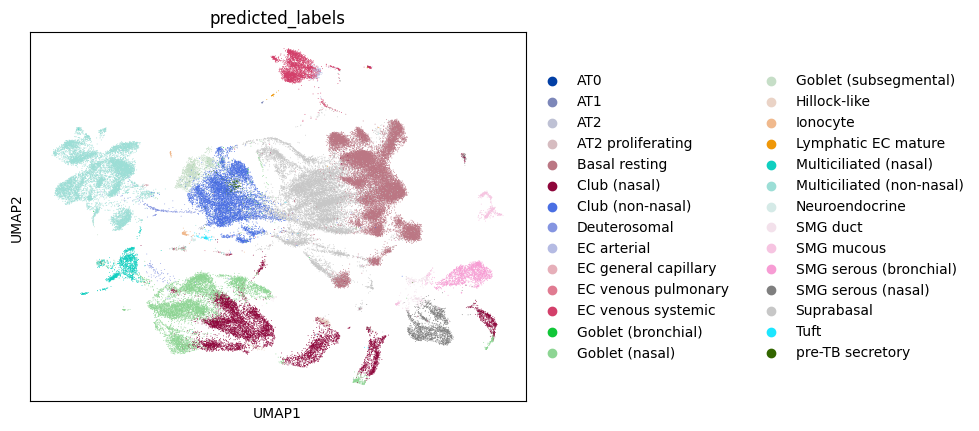

In [27]:
sc.pl.umap(cp, color=['predicted_labels'])

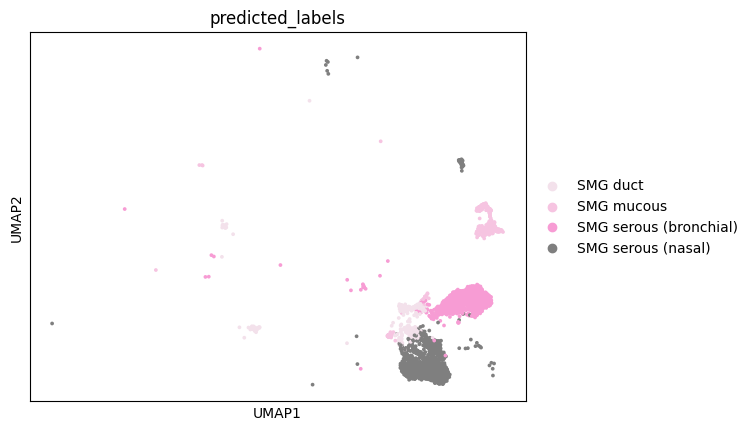

In [28]:
smg = ['SMG duct', 'SMG mucous', 'SMG serous (bronchial)', 'SMG serous (nasal)']
sc.pl.umap(
    cp[cp.obs['predicted_labels'].isin(smg)],
    color=['predicted_labels'])

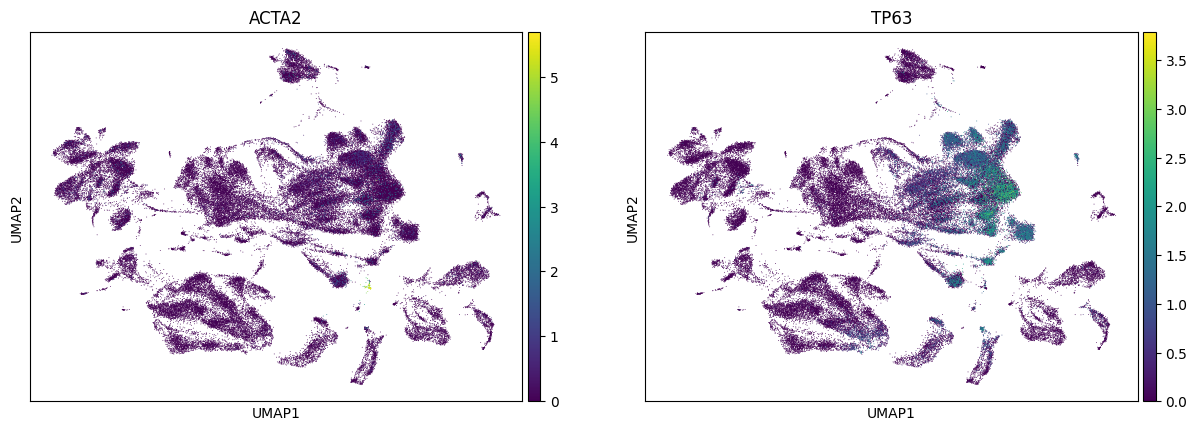

In [29]:
sc.pl.umap(cp, color=['ACTA2', 'TP63'])

### Simplify annotation

In [23]:
data_dict = {
    "AT0": "AT0",
    "AT1": "AT1",
    "AT2": "AT2",
    "AT2 proliferating": "AT2",
    "Basal resting": "Basal",
    "Club (nasal)": "Club",
    "Club (non-nasal)": "Club",
    "Deuterosomal": "Ciliated",
    "EC aerocyte capillary": "Endothelial",
    "EC arterial": "Endothelial",
    "EC general capillary": "Endothelial",
    "EC venous pulmonary": "Endothelial",
    "EC venous systemic": "Endothelial",
    "Goblet (bronchial)": "Goblet",
    "Goblet (nasal)": "Goblet",
    "Goblet (subsegmental)": "Goblet",
    "Hillock-like": "Basal",
    "Ionocyte": "Ionocyte",
    "Lymphatic EC differentiating": "Endothelial",
    "Lymphatic EC mature": "Endothelial",
    "Lymphatic EC proliferating": "Endothelial",
    "Multiciliated (nasal)": "Ciliated",
    "Multiciliated (non-nasal)": "Ciliated",
    "Neuroendocrine": "Neuroendocrine",
    "SMG duct": "Club",
    "SMG mucous": "Goblet",
    "SMG serous (bronchial)": "Club",
    "SMG serous (nasal)": "Club",
    "Suprabasal": "Basal",
    "Tuft": "Tuft",
    "pre-TB secretory": "Club"
}

In [24]:
human_lung_cells_epithelial.obs['simplified_celltype'] = human_lung_cells_epithelial.obs['predicted_labels'].copy().map(data_dict)

In [25]:
human_lung_cells_epithelial.obs['simplified_celltype'].value_counts()

Basal             33713
Club              19164
Ciliated          10836
Goblet             9344
Endothelial        2828
Ionocyte            129
Tuft                 71
Neuroendocrine       29
AT2                  16
AT1                  12
AT0                   1
Name: simplified_celltype, dtype: int64

In [26]:
# remove the single AT0 cell; we think it represents a transitional cell
human_lung_cells_epithelial = human_lung_cells_epithelial[human_lung_cells_epithelial.obs['simplified_celltype'] != 'AT0']

In [27]:
# make sure every cell has been assigned a type
assert sum(human_lung_cells_epithelial.obs['simplified_celltype'].value_counts()) == human_lung_cells_epithelial.shape[0]

In [28]:
human_lung_cells_epithelial.uns['log1p']

{'base': None}

In [30]:
human_lung_cells_epithelial.obs

,sample,predicted_labels,simplified_celltype
AAACCTGAGATAGTCA-1-0,0,Basal resting,Basal
AAACCTGAGGCTATCT-1-0,0,Suprabasal,Basal
AAACCTGAGTCAAGGC-1-0,0,Suprabasal,Basal
AAACCTGCACCCATGG-1-0,0,Basal resting,Basal
AAACCTGCACGGTGTC-1-0,0,Basal resting,Basal
...,...,...,...
TTTCCTCGTCAGTGGA-1-34,34,Suprabasal,Basal
TTTGGTTCAGTCGATT-1-34,34,Basal resting,Basal
TTTGGTTCATTTCAGG-1-34,34,Suprabasal,Basal
TTTGTCAAGTTCCACA-1-34,34,Club (non-nasal),Club


In [32]:
human_lung_cells_epithelial.shape

(76142, 32739)

In [36]:
# human_lung_cells_epithelial.write(os.path.join(ref_dir, "Barbry_Leroy_2020_epithelial_annot_simplified.h5ad"))

... storing 'simplified_celltype' as categorical
